Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel $\rightarrow$ Restart) and then **run all cells** (in the menubar, select Cell $\rightarrow$ Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name and collaborators below:

In [ ]:
NAME = "Glory Ly"
COLLABORATORS = ""

In [103]:
import os
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## PART 1: DATA COLLECTION AND CLEANING ##

In [133]:
# Load the dataset
gym_data = pd.read_csv("gym_members_exercise_tracking.csv") #dataset from kaggle

gymdf = pd.DataFrame(gym_data) #load into dataframe

print("gym dataset shape: ",gymdf.shape)
print("\n\n")

#check for missing values
print("Missing values per column:")
print(gym_data.isnull().sum())
print("\n\n")
    
print(gymdf.head()) #check if loaded
print("\n\n ")

print(gymdf.info())#check structure
print("\n\n")

#checking for duplications
print("Number of duplicated rows: ", gymdf.duplicated().sum())

gym dataset shape:  (973, 15)



Missing values per column:
Age                              0
Gender                           0
Weight (kg)                      0
Height (m)                       0
Max_BPM                          0
Avg_BPM                          0
Resting_BPM                      0
Session_Duration (hours)         0
Calories_Burned                  0
Workout_Type                     0
Fat_Percentage                   0
Water_Intake (liters)            0
Workout_Frequency (days/week)    0
Experience_Level                 0
BMI                              0
dtype: int64



   Age  Gender  Weight (kg)  Height (m)  Max_BPM  Avg_BPM  Resting_BPM  \
0   56    Male         88.3        1.71      180      157           60   
1   46  Female         74.9        1.53      179      151           66   
2   32  Female         68.1        1.66      167      122           54   
3   25    Male         53.2        1.70      190      164           56   
4   38    Male         46.1  

In [82]:
#helper function to detect outliers via IQR method
def detect_outliers_iqr(column):
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = column[(column < lower_bound) | (column > upper_bound)]
    return outliers

#apply outlier detection to numerical columns
outlier_summary = {}
for col in gymdf.select_dtypes(include=['float64', 'int64']).columns:
    outliers = detect_outliers_iqr(gymdf[col])
    outlier_summary[col] = outliers

#print outliers found in each column
for col, outliers in outlier_summary.items():
    print(f"Outliers in '{col}':")
    print(outliers)
    print("\n")

Outliers in 'Age':
Series([], Name: Age, dtype: int64)


Outliers in 'Weight (kg)':
96     129.0
122    129.5
180    128.2
283    128.4
291    128.4
593    129.9
614    128.4
648    127.9
854    129.2
Name: Weight (kg), dtype: float64


Outliers in 'Height (m)':
Series([], Name: Height (m), dtype: float64)


Outliers in 'Max_BPM':
Series([], Name: Max_BPM, dtype: int64)


Outliers in 'Avg_BPM':
Series([], Name: Avg_BPM, dtype: int64)


Outliers in 'Resting_BPM':
Series([], Name: Resting_BPM, dtype: int64)


Outliers in 'Session_Duration (hours)':
Series([], Name: Session_Duration (hours), dtype: float64)


Outliers in 'Calories_Burned':
90     1688.0
99     1625.0
124    1701.0
475    1622.0
511    1725.0
572    1646.0
646    1675.0
712    1766.0
728    1634.0
910    1783.0
Name: Calories_Burned, dtype: float64


Outliers in 'Fat_Percentage':
Series([], Name: Fat_Percentage, dtype: float64)


Outliers in 'Water_Intake (liters)':
Series([], Name: Water_Intake (liters), dtype: float64)



Text(0.5, 1.0, 'BMI')

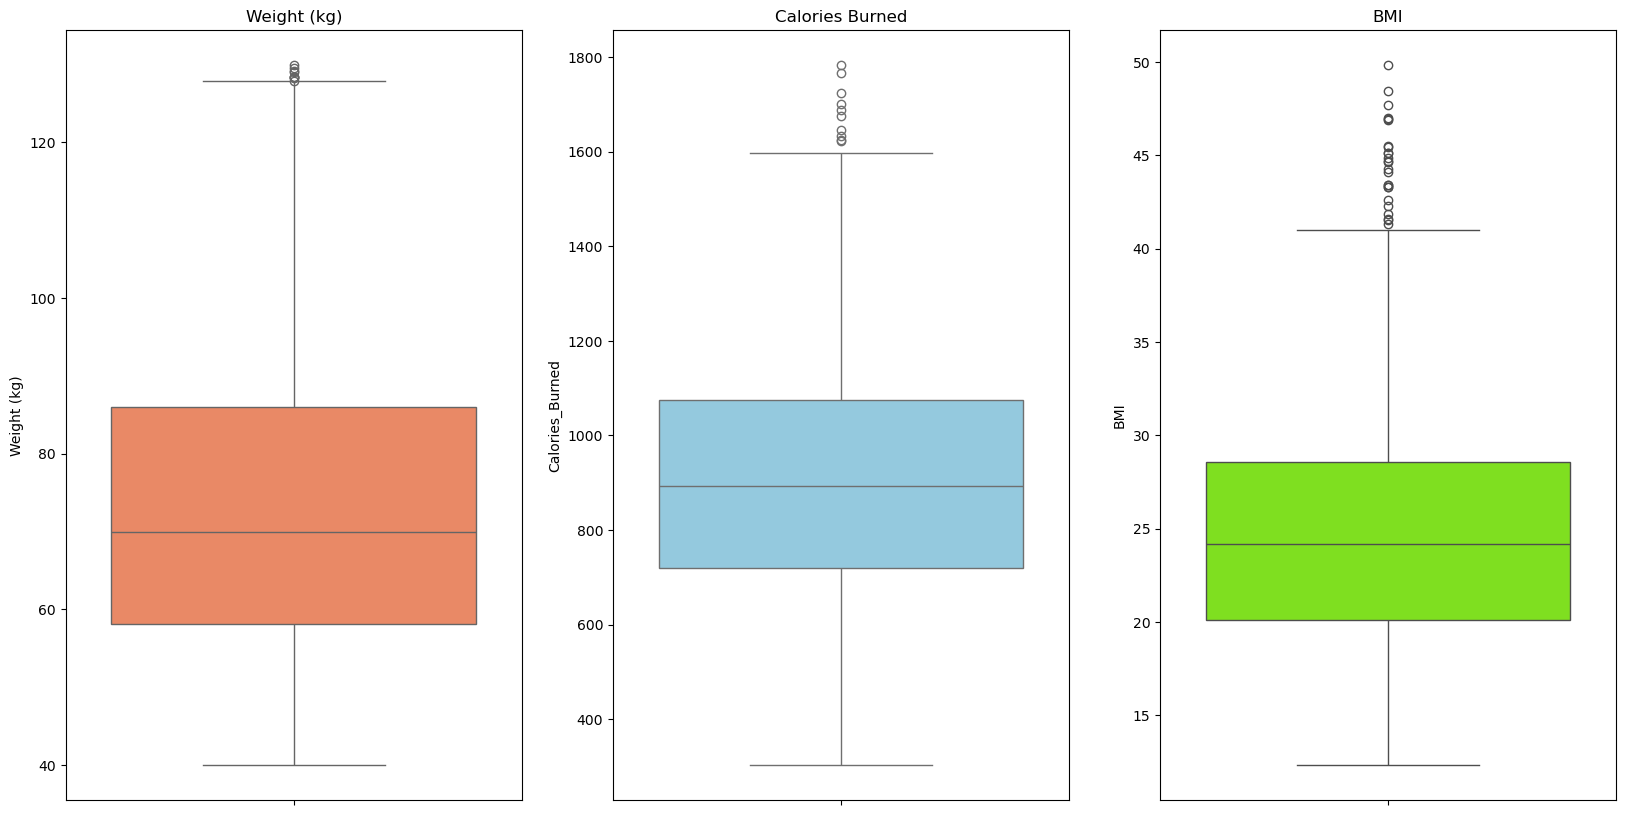

In [90]:
#using seaborn to display outliers visually: 
plt.figure(figsize=(20,10))

# First subplot: Weight
plt.subplot(1,3,1)
sns.boxplot(y=gymdf["Weight (kg)"], color="#FF7F50")
plt.title("Weight (kg)")

# Second subplot: Calories Burned
plt.subplot(1,3,2)
sns.boxplot(y=gymdf["Calories_Burned"], color="#87CEEB")
plt.title("Calories Burned")

# Third subplot: BMI
plt.subplot(1,3,3)
sns.boxplot(y=gymdf["BMI"], color="#7FFF00")
plt.title("BMI")

<p> Since the data is simulated I'll replace outliers with averages in order to fit regression model easier. </p>

In [127]:
numerical_cols = ['Age', 'Weight (kg)', 'Height (m)', 'Max_BPM', 'Avg_BPM', 'Resting_BPM',
                  'Session_Duration (hours)', 'Calories_Burned', 'Fat_Percentage',
                  'Water_Intake (liters)', 'Workout_Frequency (days/week)', 'BMI']

category_column = 'Workout_Type'  # Using 'Workout_Type' for categorization

def replace_w_mean(data, column, category_column, outliers):  # Corrected function name
    for category in data[category_column].unique():
        category_mask = (data[category_column] == category) & outliers
        non_outlier_mask = (data[category_column] == category) & ~outliers
        category_mean = data.loc[non_outlier_mask, column].mean()
        if not np.isnan(category_mean):
            data.loc[category_mask, column] = category_mean  # Indentation fix

for col in numerical_cols:
    outliers = identify_outliers_iqr(gymdf, col)  # Using 'gymdf'
    if outliers.any():
        replace_w_mean(gymdf, col, category_column, outliers)  # Using 'gymdf' and corrected function

In [128]:
#check to see if values were replaced
gymdf.describe()

,Age,Weight (kg),Height (m),Max_BPM,Avg_BPM,Resting_BPM,Session_Duration (hours),Calories_Burned,Fat_Percentage,Water_Intake (liters),Workout_Frequency (days/week),Experience_Level,BMI
count,973.000000,973.000000,973.00000,973.000000,973.000000,973.000000,973.000000,973.000000,973.000000,973.000000,973.000000,973.000000,973.00000
mean,38.683453,73.339194,1.72258,179.883864,143.766701,62.223022,1.256423,897.343590,24.976773,2.626619,3.321686,1.809866,24.39332
std,12.180928,20.532605,0.12772,11.525686,14.345101,7.327060,0.343033,260.695515,6.259419,0.600172,0.913047,0.739693,5.83102
min,18.000000,40.000000,1.50000,160.000000,120.000000,50.000000,0.500000,303.000000,10.000000,1.500000,2.000000,1.000000,12.32000
25%,28.000000,58.100000,1.62000,170.000000,131.000000,56.000000,1.040000,720.000000,21.300000,2.200000,3.000000,1.000000,20.11000
50%,40.000000,70.000000,1.71000,180.000000,143.000000,62.000000,1.260000,891.000000,26.200000,2.600000,3.000000,2.000000,24.01000
75%,49.000000,85.500000,1.80000,190.000000,156.000000,68.000000,1.460000,1070.000000,29.300000,3.100000,4.000000,2.000000,27.97000
max,59.000000,127.800000,2.00000,199.000000,169.000000,74.000000,2.000000,1598.000000,35.000000,3.700000,5.000000,3.000000,41.03000


In [137]:
#Conversion to US Metrics

# Conversion factors
KG_TO_LBS = 2.20462
M_TO_FT = 3.28084

gymdf['Weight (lbs)'] = gymdf['Weight (kg)'] * KG_TO_LBS
gymdf['Height (ft)'] = gymdf['Height (m)'] * M_TO_FT

#drop old columns
gymdf = gymdf.drop(['Weight (kg)','Height (m)'], axis = 1)

# Display the first few rows with the new columns
print(gymdf.head())


   Age  Gender  Max_BPM  Avg_BPM  Resting_BPM  Session_Duration (hours)  \
0   56    Male      180      157           60                      1.69   
1   46  Female      179      151           66                      1.30   
2   32  Female      167      122           54                      1.11   
3   25    Male      190      164           56                      0.59   
4   38    Male      188      158           68                      0.64   

   Calories_Burned Workout_Type  Fat_Percentage  Water_Intake (liters)  \
0           1313.0         Yoga            12.6                    3.5   
1            883.0         HIIT            33.9                    2.1   
2            677.0       Cardio            33.4                    2.3   
3            532.0     Strength            28.8                    2.1   
4            556.0     Strength            29.2                    2.8   

   Workout_Frequency (days/week)  Experience_Level    BMI  Weight (lbs)  \
0                            

## PART 2: SQL COMPONENET
#### Using SQL for partial data anaylsis

In [111]:
# Create a SQLite database connection
conn = sqlite3.connect("gym_members.db")

# Create the table
create_table_query = """
CREATE TABLE IF NOT EXISTS GymMembers (
    ID INTEGER PRIMARY KEY AUTOINCREMENT,
    Age INTEGER,
    Gender TEXT,
    Weight REAL,
    Height REAL,
    Max_BPM INTEGER,
    Avg_BPM INTEGER,
    Resting_BPM INTEGER,
    Session_Duration REAL,
    Calories_Burned REAL,
    Workout_Type TEXT,
    Fat_Percentage REAL,
    Water_Intake REAL,
    Workout_Frequency INTEGER,
    Experience_Level INTEGER,
    BMI REAL
);
"""
conn.execute(create_table_query)
conn.commit()

In [112]:
# Write data to the SQLite table
gym_data.to_sql("GymMembers", conn, if_exists="replace", index=False)

973

In [113]:
#Insert myeself into table 
insert_query = """
INSERT INTO GymMembers (
    Age, Gender, "Weight (kg)", "Height (m)", Max_BPM, Avg_BPM, Resting_BPM, 
    "Session_Duration (hours)", Calories_Burned, Workout_Type, Fat_Percentage, 
    "Water_Intake (liters)", Experience_Level, BMI
) 
VALUES (
    22, 'Male', 52.16, 1.7, 177, 130, 80, 
    1, 800, 'Cardio', 10, 0.8, 1, 12
);
"""
conn.execute(insert_query)
conn.commit()

In [114]:
#check if my entry is added
check_query = """
SELECT * FROM GymMembers
WHERE Age = 22 AND Gender = 'Male' AND "Weight (kg)" = 52.16;
"""

cursor = conn.execute(check_query)
result = cursor.fetchall()

# Print the result
if result:
    print("Entry successfully added:", result)
else:
    print("No matching entry found.")


Entry successfully added: [(22, 'Male', 52.16, 1.7, 177, 130, 80, 1.0, 800.0, 'Cardio', 10.0, 0.8, None, 1, 12.0)]


In [115]:
# Query the table
query = "SELECT Age, Gender, BMI FROM GymMembers WHERE Gender = 'Male' AND BMI > 25;"
df = pd.read_sql(query, conn)
print("All male gym members greater than 25 BMI \n")
print(df)

query = "SELECT Age, Gender, Calories_Burned FROM GymMembers ORDER BY Calories_Burned DESC LIMIT 5;"
df = pd.read_sql(query, conn)
print("top 5 calories burned \n")
print(df)

query = "SELECT AVG(BMI) AS Avg_BMI, (SUM((BMI - (SELECT AVG(BMI) FROM GymMembers)) * (BMI - (SELECT AVG(BMI) FROM GymMembers))) / (COUNT(*) - 1)) AS Variance FROM GymMembers;"
df = pd.read_sql(query, conn)
print("standard deviation of BMI across all members \n")
print(round(df,3))




All male gym members greater than 25 BMI 

     Age Gender    BMI
0     56   Male  30.20
1     28   Male  32.34
2     28   Male  30.07
3     41   Male  43.31
4     57   Male  43.40
..   ...    ...    ...
282   57   Male  30.63
283   24   Male  28.77
284   25   Male  25.69
285   32   Male  37.74
286   46   Male  33.38

[287 rows x 3 columns]
top 5 calories burned 

   Age Gender  Calories_Burned
0   32   Male           1783.0
1   19   Male           1766.0
2   39   Male           1725.0
3   26   Male           1701.0
4   25   Male           1688.0
standard deviation of BMI across all members 

   Avg_BMI  Variance
0   24.899    44.493


In [135]:
#BMI trends across gender
query = "SELECT Gender, AVG(BMI) AS Average_BMI, MIN(BMI) AS Min_BMI, MAX(BMI) AS Max_BMI FROM GymMembers GROUP BY Gender;"
df = pd.read_sql(query,conn)
print("BMI Trends across genders: \n",df)


BMI Trends across genders: 
    Gender  Average_BMI  Min_BMI  Max_BMI
0  Female    22.727835    12.47    35.04
1    Male    26.857891    12.00    49.84


---

In [117]:
query = "SELECT Age, Resting_BPM FROM GymMembers;" 
df  = pd.read_sql(query,conn)
print(df)

# Load data into pandas
AgeToResting = pd.read_sql_query("SELECT Age, Resting_BPM FROM GymMembers;", conn)

# Calculate correlation
correlation = AgeToResting.corr()
print(correlation)


     Age  Resting_BPM
0     56           60
1     46           66
2     32           54
3     25           56
4     38           68
..   ...          ...
969   25           56
970   59           53
971   32           62
972   46           66
973   22           80

[974 rows x 2 columns]
                  Age  Resting_BPM
Age          1.000000     0.000935
Resting_BPM  0.000935     1.000000


In [118]:
query = '''SELECT Experience_Level, AVG("Session_Duration (hours)") AS Average_Session_Duration FROM GymMembers GROUP BY Experience_Level; '''
df = pd.read_sql(query,conn)
print("Average Session Duration across Experience Levels \n")
print(df)


Average Session Duration across Experience Levels 

   Experience_Level  Average_Session_Duration
0                 1                  1.010186
1                 2                  1.247882
2                 3                  1.759267


In [119]:
query = '''SELECT Workout_Type, AVG(Calories_Burned) AS Average_Calories_Burned
FROM GymMembers
GROUP BY Workout_Type
ORDER BY Average_Calories_Burned DESC
LIMIT 1;
'''
df = pd.read_sql(query,conn)
print("Workout type with most calories burend \n")
print(df)


Workout type with most calories burend 

  Workout_Type  Average_Calories_Burned
0         HIIT                925.80543


In [120]:
query = '''SELECT AVG(Fat_Percentage) AS Average_Fat_Percentage
FROM GymMembers
WHERE "Workout_Frequency (days/week)" > 3;
'''
df = pd.read_sql(query,conn)
print("average body fat percentage for members working out more than 3 days a week\n")
print(df)

average body fat percentage for members working out more than 3 days a week

   Average_Fat_Percentage
0               21.433824


In [121]:
query = '''SELECT 
    ROUND("Water_Intake (liters)", 1) AS Water_Intake_Range, 
    AVG(Calories_Burned) AS Average_Calories_Burned
FROM GymMembers
GROUP BY Water_Intake_Range
ORDER BY Water_Intake_Range;
'''

df = pd.read_sql(query,conn)
print("daily water intake vs calories burned")
print(df)

daily water intake vs calories burned
    Water_Intake_Range  Average_Calories_Burned
0                  0.8               800.000000
1                  1.5               819.750000
2                  1.6               798.538462
3                  1.7               740.925926
4                  1.8               806.235294
5                  1.9               770.709677
6                  2.0               791.760870
7                  2.1               810.561404
8                  2.2               847.285714
9                  2.3               810.847458
10                 2.4               803.854545
11                 2.5               837.666667
12                 2.6               782.280000
13                 2.7              1075.439024
14                 2.8               853.740741
15                 2.9               856.029412
16                 3.0               886.863636
17                 3.1               829.689655
18                 3.2               803.954545
19

## PART 3:  EDA
#### Exploring data with visuals

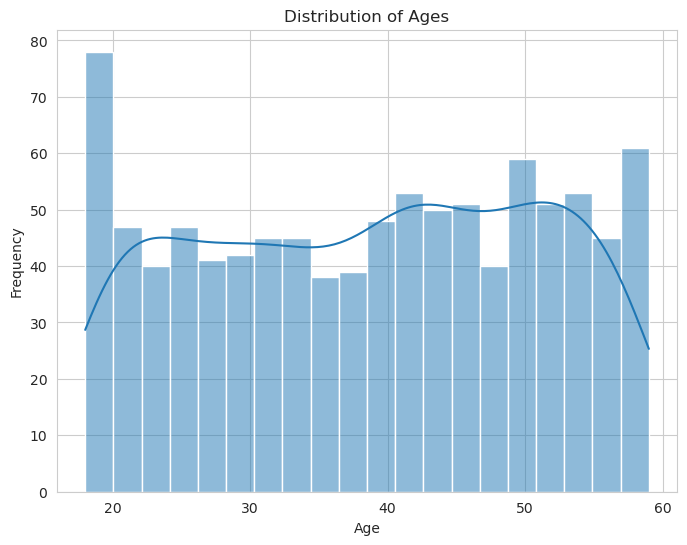

In [162]:
sns.set_style('whitegrid')
#Distribution of Age across data
plt.figure(figsize=(8, 6))
sns.histplot(gymdf['Age'], bins=20, kde=True)
plt.title('Distribution of Ages')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

<p> Basic historgram of age distribution, peaks at 40, 50, and a large frequency at 20. </p>

In [ ]:
# Scatterplot analyzing the relationship between age and calories burned with regression line
plt.figure(figsize=(8, 6))
sns.regplot(data=gym_data, x='Age', y='Calories_Burned', scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
plt.title('Age vs. Calories Burned')
plt.xlabel('Age')
plt.ylabel('Calories Burned')
plt.show()

/tmp/ipykernel_3143377/4105918903.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_group_frequency = gym_data.groupby('Age_Group')['Workout_Frequency (days/week)'].mean()


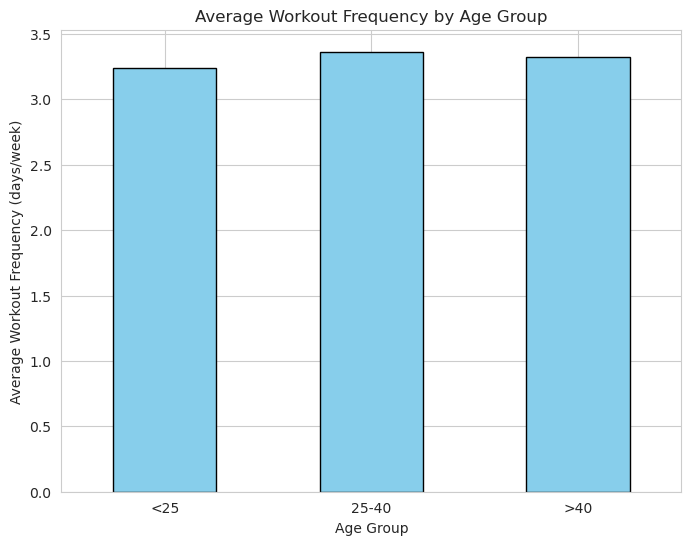

In [167]:
# Group by age group and calculate mean workout frequency
age_group_frequency = gym_data.groupby('Age_Group')['Workout_Frequency (days/week)'].mean()

# Bar plot
plt.figure(figsize=(8, 6))
age_group_frequency.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Average Workout Frequency by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Average Workout Frequency (days/week)')
plt.xticks(rotation=0)
plt.show()

/tmp/ipykernel_3143377/2605736570.py:2: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_data = gym_data.pivot_table(index='Age_Group', columns='Experience_Level', values='Workout_Frequency (days/week)', aggfunc='mean')


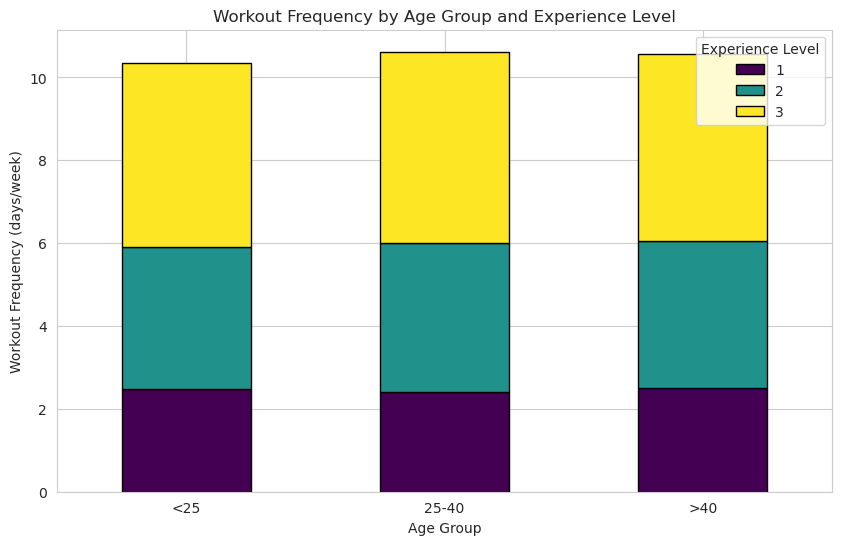

In [170]:
# Pivot data for stacked bar plot
pivot_data = gym_data.pivot_table(index='Age_Group', columns='Experience_Level', values='Workout_Frequency (days/week)', aggfunc='mean')

# Stacked bar plot
pivot_data.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='viridis', edgecolor='black')
plt.title('Workout Frequency by Age Group and Experience Level')
plt.xlabel('Age Group')
plt.ylabel('Workout Frequency (days/week)')
plt.legend(title='Experience Level')
plt.xticks(rotation=0)
plt.show()

In [ ]:
#correlation matrix between numerical variables
numerical_cols = gymdf.select_dtypes(include=['int64', 'float64']).columns
numerical_df = gymdf[numerical_cols]
correlation_matrix = numerical_df.corr()

# Create the heatmap
plt.figure(figsize=(12, 10))  # Adjust the figure size as needed
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of Numerical Variables')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels
plt.yticks(rotation=0) # Ensure y-axis labels do not rotate
plt.tight_layout() #Adjust layout so labels don't get cut off
plt.show()

<p> For all purposes to answer my question this correlation matrix shows a weak correlation between age and other workout factors... Not looking good.</p>

## PART 4: ML FITTING

#### EDA shows that the correlation between age and other factors is negligble. in which case, I'll attempt to find features that effect age on workout behavior and analytics

#### If age does not effect workout regimens greatly, maybe monitoring workout intensity can

In [186]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Define features and target
X = gym_data[['Age', 'Experience_Level', 'Workout_Frequency (days/week)', 'Session_Duration (hours)', 'BMI']]
y = gym_data['Workout_Intensity']  #created variable

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))


# Feature importance
importances = model.feature_importances_
for feature, importance in zip(X.columns, importances):
    print(f"{feature}: {importance:.2f}")

              precision    recall  f1-score   support

        High       0.83      0.72      0.77        72
         Low       0.93      0.74      0.82        19
      Medium       0.79      0.88      0.83       104

    accuracy                           0.81       195
   macro avg       0.85      0.78      0.81       195
weighted avg       0.82      0.81      0.81       195

Age: 0.14
Experience_Level: 0.13
Workout_Frequency (days/week): 0.06
Session_Duration (hours): 0.50
BMI: 0.17


In [ ]:
# Features and their importance scores
features = ['Age', 'Experience_Level', 'Workout_Frequency (days/week)', 'Session_Duration (hours)', 'BMI']
importances = [0.14, 0.13, 0.06, 0.50, 0.17]

# Bar plot
plt.figure(figsize=(8, 6))
plt.barh(features, importances, color='skyblue')
plt.title('Feature Importance')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.gca().invert_yaxis()  # Reverse order for better readability
plt.show()

